# **Generating Quotes using LSTM**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

from tensorflow import keras

from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from tensorflow.keras.layers import InputLayer
from keras.models import Sequential
import keras.utils as ku
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
pip install keras --upgrade


     |████████████████████████████████| 1.7 MB 2.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.0
    Uninstalling Keras-2.4.0:
      Successfully uninstalled Keras-2.4.0
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Loading the dataset
data = pd.read_json('../input/quotes-dataset/quotes.json')
print(data.shape)
data.head()

(48391, 5)


,Quote,Author,Tags,Popularity,Category
0,"Don't cry because it's over, smile because it ...",Dr. Seuss,"[attributed-no-source, cry, crying, experience...",0.155666,life
1,"Don't cry because it's over, smile because it ...",Dr. Seuss,"[attributed-no-source, cry, crying, experience...",0.155666,happiness
2,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"[attributed-no-source, best, life, love, mista...",0.129122,love
3,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"[attributed-no-source, best, life, love, mista...",0.129122,life
4,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"[attributed-no-source, best, life, love, mista...",0.129122,truth


The dataset has features such as:
* Quote
* Author
* Tags
* Popularity
* Category

But for our task at hand, we are interested in only the Quote feature of the dataset. If you look at the Quote column, a single quote is attributed to multiple categories such as life, happiness, etc. So, we will drop the duplicate quotes and consider only unique quotes.

In [4]:
# Dropping duplicates and creating a list containing all the quotes
quotes = data['Quote'].drop_duplicates()
print(f"Total Unique Quotes: {quotes.shape}")

# Considering only top 3000 quotes
quotes_filt = quotes.sample(3000)
print(f"Filtered Quotes: {quotes_filt.shape}")
all_quotes = list(quotes_filt)
all_quotes[:2]

Total Unique Quotes: (36937,)
Filtered Quotes: (3000,)


["I am not good at noticing when I'm happy, except in retrospect.",
 'Libraries should be open to all - except the censor.[Response to questionnaire in Saturday Review, October 29 1960]']

Next step is to preprocess and prepare the data for a Text Generation model. 

First, we will tokenize the text usign Keras **Tokenizer** class to create a vocabulary and convert the text into sequence of token indexes.

There are two levels at which you can generate text:
1. Character level
2. Word level

Here, first we will focus on word level text generation. Suppose, let's consider the quote **"Don't cry because it's over, smile because it happened"**, we have to prepare our data in the format below:
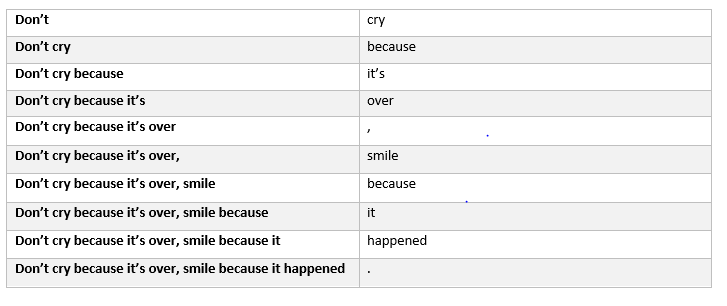
The reason why we need to prepare our data in such a way is very intuitive because, even when we write any piece of text, we will form sentences word by word i.e., the next word we write depends upon the previous words we have used. So, when we give the model sequences in this format, it will also try to learn the sequence and predict the next possible word exactly how we do.

In [5]:
# Tokeinization
tokenizer = Tokenizer()

# Function to create the sequences
def generate_sequences(corpus):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    print(f"Total unique words in the text corpus: {total_words}")
    input_sequences = []
    for line in corpus:
        seq = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(seq)):
            ngram_seq = seq[:i+1]
            input_sequences.append(ngram_seq)
            
    return input_sequences, total_words

# Generating sequences
input_sequences, total_words = generate_sequences(all_quotes)
input_sequences[:5]

Total unique words in the text corpus: 9471


[[8, 97],
 [8, 97, 14],
 [8, 97, 14, 73],
 [8, 97, 14, 73, 44],
 [8, 97, 14, 73, 44, 3903]]

Now that we have the data in required format, but each sequences are of different length. So, before feeding into the model, we will first pad the sequences to same length.

Also, we need to create predictor and label from the prepared sequences by taking all the tokens except the last one as predictors and the last token as label (For example, think of it like the data in the above table: "Don't cry" as predictors and "because" as label).

In [6]:
# Generating predictors and labels from the padded sequences
def generate_input_sequence(input_sequences):
    maxlen = max([len(x) for x in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen=maxlen)
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, maxlen

predictors, label, maxlen = generate_input_sequence(input_sequences)
predictors[:1], label[:1]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8]],
       dtype=int32),
 array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

Finally, we are done with the preprocessing part of task. Now, we will start building our LSTM model for text generation. You can think of this model as a multiclass text classification task- given the previous words, the model will predict the next word which has high probability.

**Model Architecture:**
* Embedding layer with the embedding dimension of 64
* LSTM Layer with 128 units with dropout
* A dense layer with number of units equal to the total words in the vocabulary with **softmax** activation since it is a mulitclass classification task.
* The optimizer we use here is **Adam**, loss is **categorical_crossentropy**, and an epoch of 50.

In [7]:
# Building the model
embedding_dim = 64

def create_model(maxlen, embedding_dim, total_words):
    model = Sequential()
    model.add(layers.Embedding(total_words, embedding_dim, input_length = maxlen))
    model.add(layers.LSTM(128, dropout=0.2))
    model.add(layers.Dense(total_words, activation='softmax'))
    
    # compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = create_model(maxlen, embedding_dim, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 86, 64)            606144    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 9471)              1221759   
Total params: 1,926,719
Trainable params: 1,926,719
Non-trainable params: 0
_________________________________________________________________


In [8]:
predictors.shape , label.shape, maxlen

((74258, 85), (74258, 9471), 86)

In [9]:
#Training the model
model.fit(predictors, label, epochs=50, batch_size=64)

Epoch 1/50
1161/1161 [==============================] - 16s 14ms/step - loss: 6.9039
Epoch 2/50
1161/1161 [==============================] - 16s 14ms/step - loss: 6.3975
Epoch 3/50
1161/1161 [==============================] - 17s 14ms/step - loss: 6.0619
Epoch 4/50
1161/1161 [==============================] - 16s 14ms/step - loss: 5.7988
Epoch 5/50
1161/1161 [==============================] - 16s 14ms/step - loss: 5.5638
Epoch 6/50
1161/1161 [==============================] - 16s 13ms/step - loss: 5.3365
Epoch 7/50
1161/1161 [==============================] - 16s 14ms/step - loss: 5.1184
Epoch 8/50
1161/1161 [==============================] - 16s 14ms/step - loss: 4.9083
Epoch 9/50
1161/1161 [==============================] - 16s 14ms/step - loss: 4.7080
Epoch 10/50
1161/1161 [==============================] - 16s 14ms/step - loss: 4.5163
Epoch 11/50
1161/1161 [==============================] - 16s 14ms/step - loss: 4.3357
Epoch 12/50
1161/1161 [==============================] - 16s 14

In [10]:
# Save the model for later use
model.save("Quotes_generator.h5")

In [11]:
# Loading the model
from keras.models import load_model

Quotes_gen = load_model("../working/Quotes_generator.h5")

In [12]:
Quotes_gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 86, 64)            606144    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 9471)              1221759   
Total params: 1,926,719
Trainable params: 1,926,719
Non-trainable params: 0
_________________________________________________________________


Now that we have our trained model, we will create a function to generate text.

The function takes in the trained model, the input words (also called seed text), how many words to genereate and maximum squence length. The function then tokenize the text, padds it and predict using our trained model.

The model predicts one word at a time. So after every prediction, we will get the word for the predicted label and append it to the seed_text. This process continues for the specified number of words you want to genereate. And once it is done, the text will then be returned.


In [13]:
# Text generating function
def generate_quote(seed_text, num_words, model, maxlen):
    
    for _ in range(num_words):
        tokens = tokenizer.texts_to_sequences([seed_text])[0]
        tokens = pad_sequences([tokens], maxlen=maxlen, padding='pre')
        
        predicted = model.predict_classes(tokens)
        
        output_word = ''
        
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text = seed_text + " " + output_word
    
    return seed_text

In [14]:
# Let's try to generate some quotes
print(generate_quote("Passion", num_words = 10, model= Quotes_gen, maxlen=maxlen))

Passion is a faucet when it is the most potent education


In [15]:
print(generate_quote("Love", num_words = 20, model= Quotes_gen, maxlen=maxlen))

Love is the only thing of the soul which prevents it possible for the truth to avoid the world without a


In [16]:
print(generate_quote("legend", num_words = 15, model= Quotes_gen, maxlen=maxlen))

legend who has ever been ashamed of anything could appreciate me illusions don’t mean i want


In [17]:
print(generate_quote("consistency matters", num_words = 15, model= Quotes_gen, maxlen=maxlen))

consistency matters is the word of the imagination of the enemy whoever lives for the truth is


In [18]:
print(generate_quote("Follow your passion", num_words = 20, model= Quotes_gen, maxlen=maxlen))

Follow your passion and your choice then you can’t lock myself into the imprisonment of past grudges and anger simplify and the other
